# Model results

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

In [2]:
sns.set_theme("notebook")
figsize = (12,8)

## lofoten800 rms deviations 

Text(0.5, 1.0, 'full period, full water column')

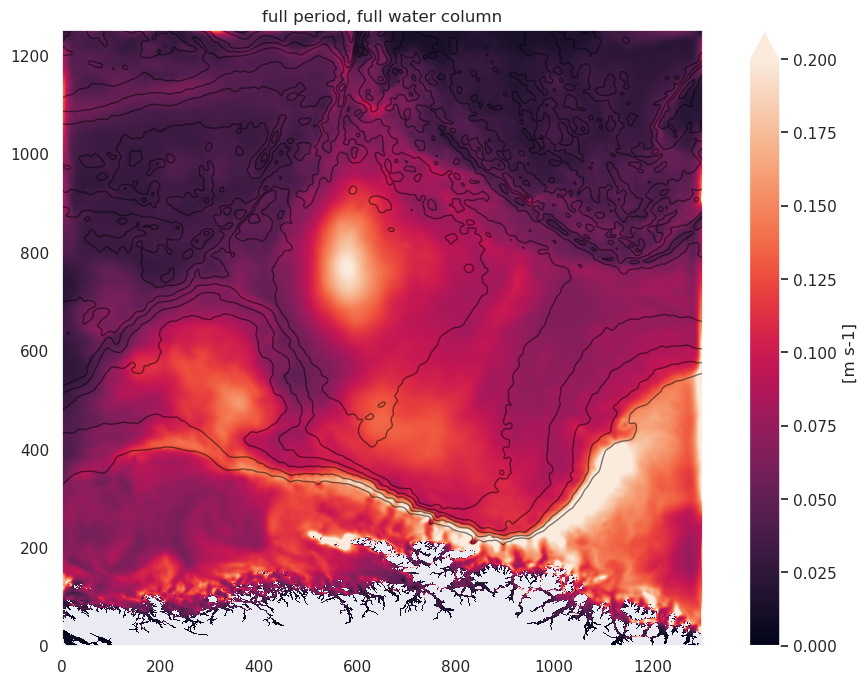

In [3]:
ds = xr.open_dataset("data/lofoten800/rms_deviation.nc")
h = xr.open_dataarray("data/lofoten800/bathymetry.nc") 

fig, ax = plt.subplots(figsize=figsize)

cm = ax.pcolormesh(ds.rms_deviation, vmin=0, vmax =0.2)
ax.contour(h, colors="black", linewidths=1, alpha=0.5)
fig.colorbar(cm, label="[m s-1]", extend="max")
ax.set_aspect("equal")

ax.set_title("full period, full water column")

## A4 rms deviations 

Text(0.5, 1.0, 'full period, full water column')

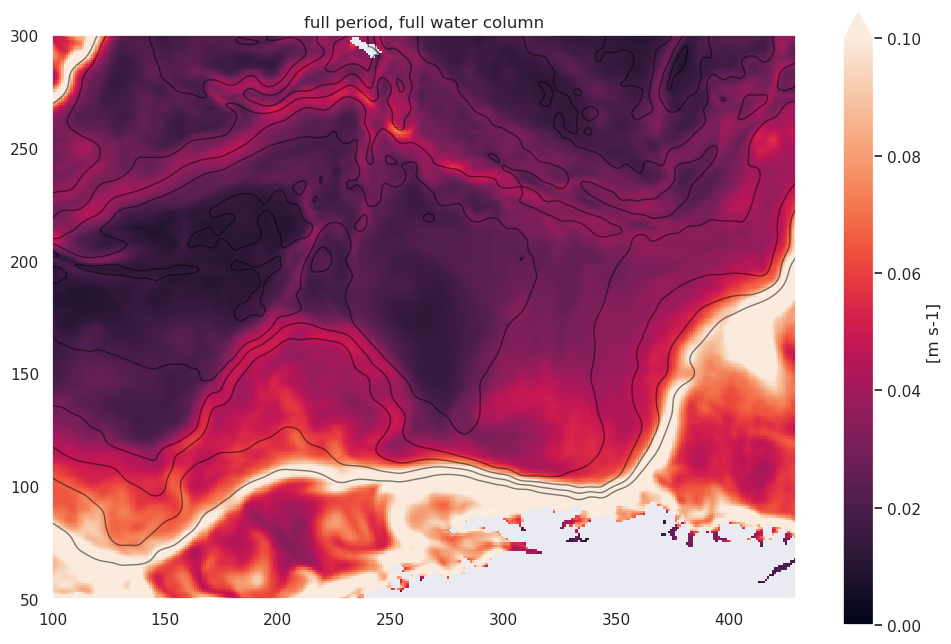

In [4]:
ds = xr.open_dataset("data/A4/rms_deviation.nc")
gridvars = xr.open_dataset("data/A4/grid_metrics.nc")

fig, ax = plt.subplots(figsize=figsize)

cm = ax.pcolormesh(ds.rms_deviation, vmin=0, vmax =0.1)
ax.contour(gridvars.h, colors="black", linewidths=1, alpha=0.5)
fig.colorbar(cm, label="[m s-1]", extend="max")

ax.set_xlim(100, 430)
ax.set_ylim(50, 300)

ax.set_aspect("equal")
ax.set_title("full period, full water column")

Text(0.5, 1.0, 'full time period, top 1000 m')

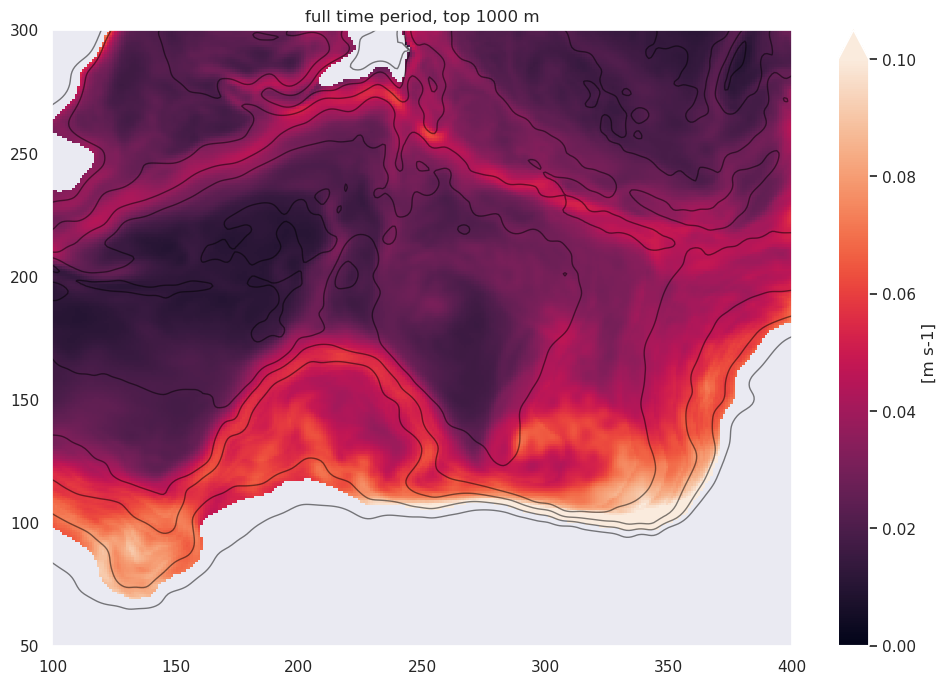

In [5]:
depth = 1000

ds = xr.open_dataset(f"data/A4/rms_deviation_{depth}.nc")
gridvars = xr.open_dataset("data/A4/grid_metrics.nc")

ds = ds.where(gridvars.h > depth)

fig, ax = plt.subplots(figsize=figsize)

cm = ax.pcolormesh(ds.rms_deviation, vmin=0, vmax =0.1)
ax.contour(gridvars.h, colors="black", linewidths=1, alpha=0.5)
fig.colorbar(cm, label="[m s-1]", extend="max")


ax.set_xlim(100, 400)
ax.set_ylim(50, 300)

ax.set_aspect("equal")
ax.set_title(f"full time period, top {depth} m")

Text(0.5, 1.0, '6 months rolling mean, top 1000 m')

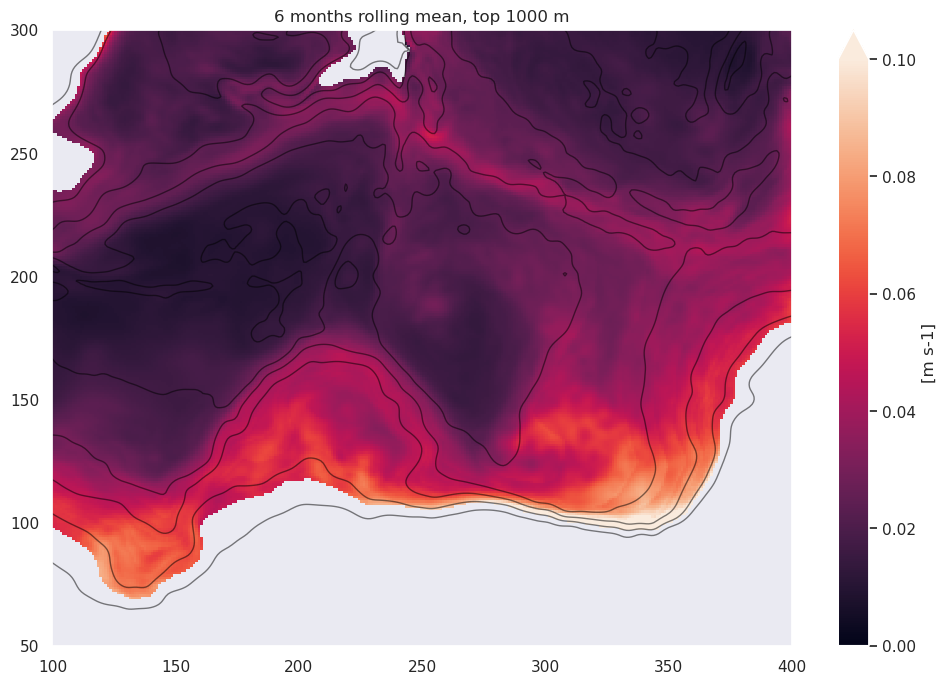

In [6]:
depth = 1000

ds = xr.open_dataset(f"data/A4/rms_deviation_{depth}_rolling.nc")
gridvars = xr.open_dataset("data/A4/grid_metrics.nc")

ds = ds.where(gridvars.h > depth)

fig, ax = plt.subplots(figsize=figsize)

cm = ax.pcolormesh(ds.rms_deviation, vmin=0, vmax =0.1)
ax.contour(gridvars.h, colors="black", linewidths=1, alpha=0.5)
fig.colorbar(cm, label="[m s-1]", extend="max")


ax.set_xlim(100, 400)
ax.set_ylim(50, 300)

ax.set_aspect("equal")
ax.set_title(f"6 months rolling mean, top {depth} m")

## Momentum budget

### Direct time integral

Formulation:
$$ 
\frac{\partial}{\partial t} \overline{C} + \oint \overline{\zeta}\overline{\mathbf{u}} \cdot \mathbf{n}\,dl + \oint \overline{\zeta'u'} \cdot \mathbf{n}\,dl = \oint \frac{\overline{{\tau}}_s}{\rho H}\cdot d\mathbf{l} - \oint \frac{C_D |u_b| {\mathbf{u}_b}}{H}\cdot d\mathbf{l}
$$

Can diagnose $\overline{C}$

$$
\overline{C} = \overline{C}_0  +  \int_{t_0}^t  F \, dt
$$

where 

$$ 
F = \oint \frac{\overline{{\tau}}_s}{\rho H}\cdot d\mathbf{l} -  \oint \frac{C_D |u_b| {\mathbf{u}_b}}{H}\cdot d\mathbf{l}  - \oint \overline{\zeta}\overline{\mathbf{u}} \cdot \mathbf{n}\,dl - \oint \overline{\zeta'u'} \cdot \mathbf{n}\,dl 
$$

### A4 direct time integral

Text(0.5, 1.0, 'A4 direct time integral')

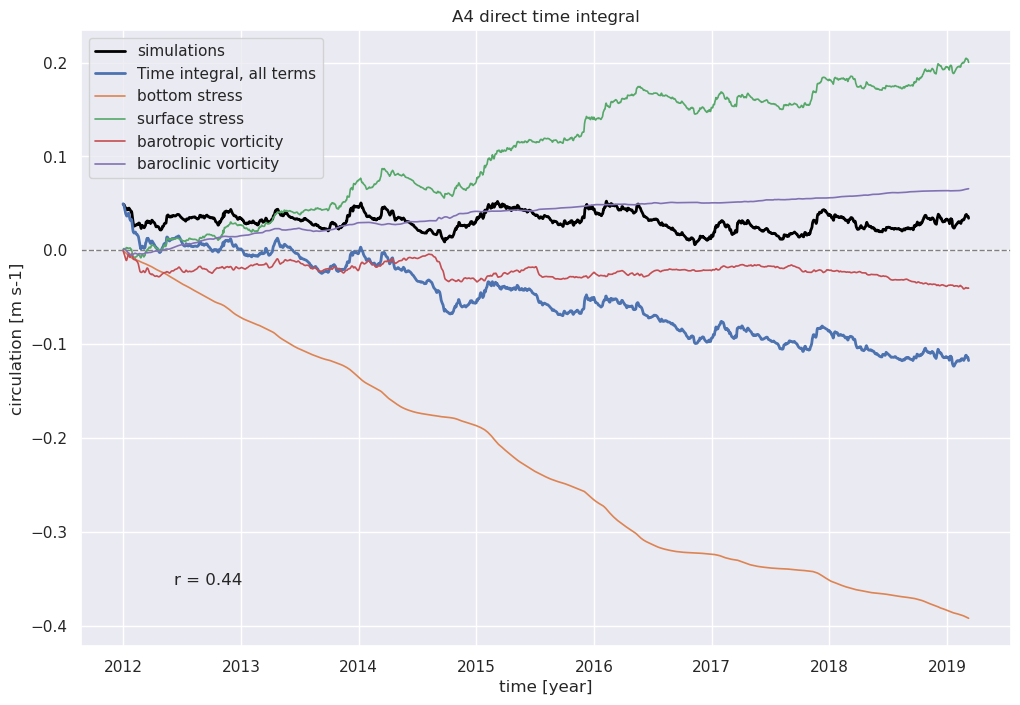

In [7]:
# Load the dataset
results = xr.open_dataset("data/A4/A4_direct_time_integrals_lofoten_h_50km.nc")
Cd = 0.003

H = 3114

results["forcing"][0,:] = -results.sel(term="ub squared")["forcing"]*Cd/H

results = results.assign_coords(term=['bottom stress', 'surface stress', 'planetary vorticity',
       'barotropic vorticity', 'baroclinic vorticity'])

all_terms = [
   'bottom stress',
   'surface stress', 
   'barotropic vorticity', 
   'baroclinic vorticity'
]

U0 = results.Ubar.isel(ocean_time=0).values

# Calculate sum of selected terms
results["all terms"] = results.forcing.sel(term=all_terms).sum("term")+U0
#results["all terms"] = results.sel(term="all terms")

ds = results.isel(ocean_time=slice(0,-1))

x = ds.Ubar.values
y = ds["all terms"].values

corr = sp.stats.pearsonr(x, y)
r = corr.statistic

#r = ds.r.values
t = ds.ocean_time.values

# Plot each individual term over time
fig, ax = plt.subplots(figsize=figsize)

ax.axhline(0, lw=1,  ls="--", color="gray")
ax.plot(t,ds.Ubar, label="simulations", color="black", lw=2)
#ax.plot(t,ds.Ub, label="bottom", color="gray", lw=2)
ax.plot(t, ds["all terms"], label="Time integral, all terms", lw=2)

ax.text(0.1, 0.1, f"r = {r:.2f}", transform=ax.transAxes)


ax.legend()
for term in all_terms:
   ax.plot(t,ds.sel(term=term).forcing, label=term, lw=1.2)
    
ax.legend()
ax.set_xlabel("time [year]")
ax.set_ylabel("circulation [m s-1]")

ax.set_title("A4 direct time integral")

### A4 time integral parametrized friction

Text(0.5, 1.0, 'A4 time integral with parametrized friction')

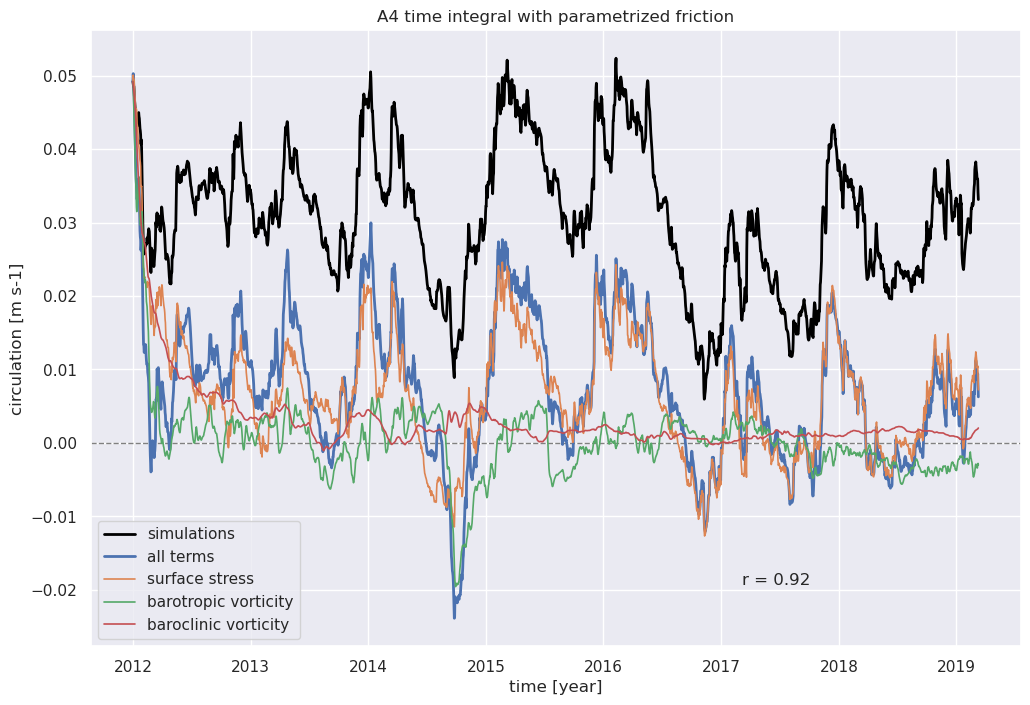

In [8]:
# Load the dataset
#ds = xr.open_dataset("data/A4/A4_quadratic_time_integrals_lofoten_h_50km.nc")
ds = xr.open_dataset("data/A4/A4_linear_time_integrals_lofoten_h_50km.nc")

t = ds.ocean_time.values

# Plot each individual term over time
fig, ax = plt.subplots(figsize=figsize)

ax.axhline(0, lw=1,  ls="--", color="gray")
ax.plot(t,ds.Ubar, label="simulations", color="black", lw=2)
#ax.plot(t,ds.Ub, label="bottom", color="gray", lw=2)
ax.plot(t, ds.sel(term="all terms").forcing, label="all terms", lw=2)

x = ds.Ubar.values
y = ds.sel(term="all terms").forcing.values

corr = sp.stats.pearsonr(x, y)
r = corr.statistic
ax.text(0.7, 0.1, f"r = {r:.2f}", transform=ax.transAxes)


ax.legend()
for term in ["surface stress", "barotropic vorticity", "baroclinic vorticity"]:
   ax.plot(t,ds.sel(term=term).forcing, label=term, lw=1.2)
    
ax.legend()
ax.set_xlabel("time [year]")
ax.set_ylabel("circulation [m s-1]")

ax.set_title("A4 time integral with parametrized friction")

### lofoten800 direct time integral

Text(0.5, 1.0, 'lofoten800 direct time integral')

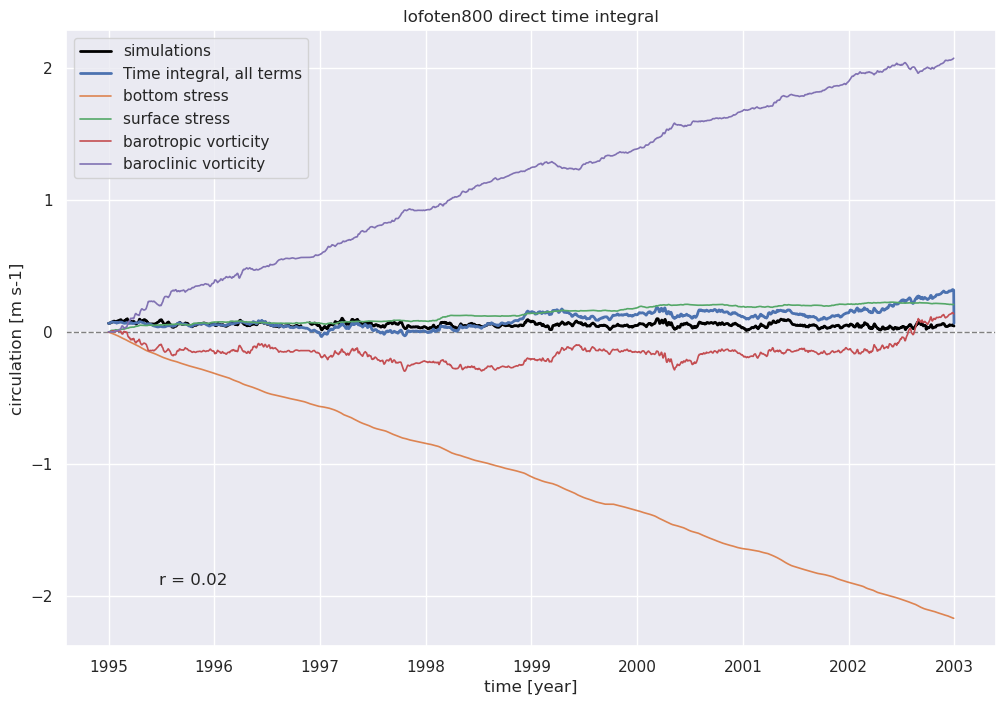

In [10]:
# Load the dataset

results = xr.open_dataset("data/lofoten800/lofoten800_direct_time_integrals_lofoten_h_50km.nc")

Cd = 0.003

H = 3114

results["forcing"][0,:] = -results.sel(term="ub squared")["forcing"]*Cd/H

results = results.assign_coords(term=['bottom stress', 'surface stress', 'planetary vorticity',
       'barotropic vorticity', 'baroclinic vorticity'])

all_terms = [
    'bottom stress', 'surface stress', 
       'barotropic vorticity', 'baroclinic vorticity'
]

U0 = results.Ubar.isel(ocean_time=0).values

# Calculate sum of selected terms
results["all terms"] = results.forcing.sel(term=all_terms).sum("term")+U0

# Choose x for correlation calculation
# Fill missing values with zeros for the correlation calculation

ds = results

#r = ds.r.values
t = ds.ocean_time.values

# Plot each individual term over time
fig, ax = plt.subplots(figsize=figsize)


x = ds.Ubar.fillna(0).values
y = ds["all terms"].fillna(0).values

corr = sp.stats.pearsonr(x, y)
r = corr.statistic
ax.text(0.1, 0.1, f"r = {r:.2f}", transform=ax.transAxes)


ax.axhline(0, lw=1,  ls="--", color="gray")
ax.plot(t,ds.Ubar, label="simulations", color="black", lw=2)
#ax.plot(t,ds.Ub, label="bottom", color="gray", lw=2)
ax.plot(t,ds["all terms"], label="Time integral, all terms", lw=2)


for term in all_terms:
   ax.plot(t,ds.sel(term=term).forcing, label=term, lw=1.2)
    
ax.legend()
ax.set_xlabel("time [year]")
ax.set_ylabel("circulation [m s-1]")

ax.set_title("lofoten800 direct time integral")

### lofoten800 time inetgral parametrized friction

Text(0.5, 1.0, 'lofoten800 time integral with parametrized friction')

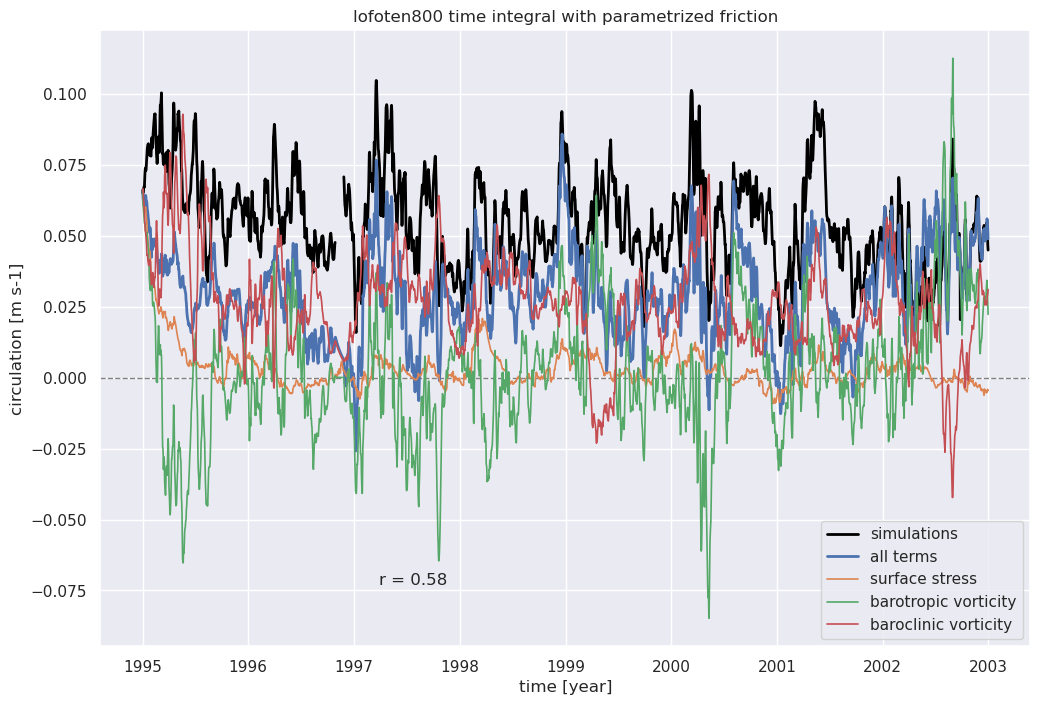

In [13]:
# Load the dataset
#ds = xr.open_dataset("data/lofoten800/lofoten800_quadratic_time_integrals_lofoten_h_50km.nc")
ds = xr.open_dataset("data/lofoten800/lofoten800_linear_time_integrals_lofoten_h_50km.nc")

t = ds.ocean_time.values

# Plot each individual term over time
fig, ax = plt.subplots(figsize=figsize)

ax.axhline(0, lw=1,  ls="--", color="gray")
ax.plot(t,ds.Ubar, label="simulations", color="black", lw=2)
#ax.plot(t,ds.Ub, label="bottom", color="gray", lw=2)
ax.plot(t, ds.sel(term="all terms").forcing, label="all terms", lw=2)

x = ds.Ubar.fillna(0).values
y = ds.sel(term="all terms").forcing.fillna(0).values

corr = sp.stats.pearsonr(x, y)
r = corr.statistic
ax.text(0.3, 0.1, f"r = {r:.2f}", transform=ax.transAxes)


ax.legend()
for term in ["surface stress", "barotropic vorticity", "baroclinic vorticity"]:
   ax.plot(t,ds.sel(term=term).forcing, label=term, lw=1.2)
    
ax.legend()
ax.set_xlabel("time [year]")
ax.set_ylabel("circulation [m s-1]")

ax.set_title("lofoten800 time integral with parametrized friction")

### Linear model

$$ 
\frac{\partial}{\partial t} \overline{C} = F - \oint \frac{R \overline{\mathbf{u}}}{H}\cdot d\mathbf{l}
$$
where
$$ 
F = \oint \frac{\overline{{\tau}}_s}{\rho H}\cdot d\mathbf{l}   - \oint \overline{\zeta}\overline{\mathbf{u}} \cdot \mathbf{n}\,dl - \oint \overline{\zeta'u'} \cdot \mathbf{n}\,dl 
$$



Solving for $\overline{C}$ gives 

$$
\overline{C} = \exp{\left(-\frac{R}{D}t\right)}  \overline{C}_0  +  \int_{t_0}^t \exp{\left(-\frac{R}{D}(t-t')\right)} F \,dt'
$$

### A4 linear model

Text(0.5, 1.0, 'A4 linear model')

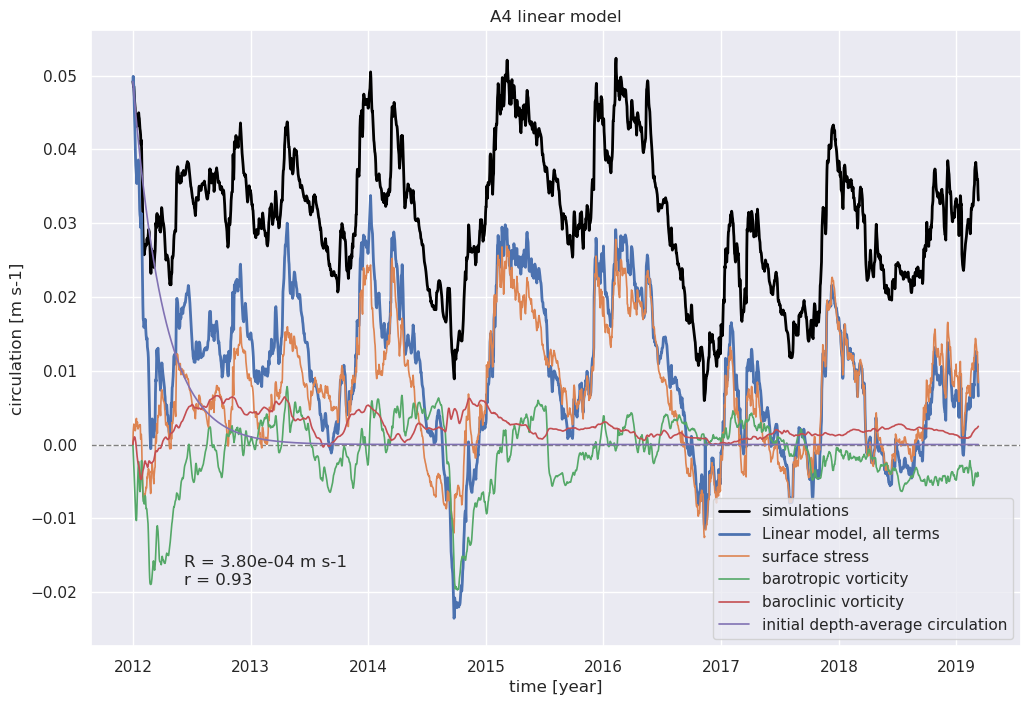

In [14]:
# Load the dataset
results = xr.open_dataset("data/A4/A4_estimates_lofoten_h_50km.nc")

# Define terms for different components of circulation
# Note: there are two different posibilities for initial condition. Comment out the one not used
all_terms = [
    
    #'initial bottom circulation', 
    'surface stress', 
    'barotropic vorticity', 
    'baroclinic vorticity',
    'initial depth-average circulation', 
]
wind_terms = [
    'initial depth-average circulation', 
    #'initial bottom circulation', 
    'surface stress'
]
vorticity_terms = [
    #'initial bottom circulation', 
    'barotropic vorticity', 
    'baroclinic vorticity',
    'initial depth-average circulation', 
]

# Calculate sum of selected terms
results["all terms"] = results.Uestimates.sel(term=all_terms).sum("term")
results["wind-driven"] = results.Uestimates.sel(term=wind_terms).sum("term")
results["vorticity-driven"] = results.Uestimates.sel(term=vorticity_terms).sum("term")

# Choose x for correlation calculation
# Fill missing values with zeros for the correlation calculation
x = results.Ubar.fillna(0).values

# Calculate Pearson correlation coefficients for each R value
rs = []
for R in results.R:
    # chose y for correlation calculation. Could also be wind-driven or vorticity-driven components
    y = results.sel(R=R)["all terms"].fillna(0).values
    corr = sp.stats.pearsonr(x, y)
    r = corr.statistic
    p = corr.pvalue
    rs.append(r)

# Store correlation coefficients in the dataset
rs = np.array(rs)
results["r"] = ("R", rs)

# Find the R value with the maximum correlation coefficient. Can also set R manually
R = results.r.idxmax().values

#R = 1e-4

# Select the dataset for the optimal R value
ds = results.sel(R=R, method="nearest")

r = ds.r.values
t = ds.ocean_time.values

# Plot each individual term over time
fig, ax = plt.subplots(figsize=figsize)

ax.axhline(0, lw=1,  ls="--", color="gray")
ax.plot(t,ds.Ubar, label="simulations", color="black", lw=2)
#ax.plot(t,ds.Ub, label="bottom", color="gray", lw=2)
ax.plot(t,ds["all terms"], label="Linear model, all terms", lw=2)

ax.text(0.1, 0.1, f"R = {R:.2e} m s-1\nr = {r:.2f}", transform=ax.transAxes)


ax.legend()
for term in all_terms:
    ax.plot(t,ds.sel(term=term).Uestimates, label=term, lw=1.2)
    
ax.legend()
ax.set_xlabel("time [year]")
ax.set_ylabel("circulation [m s-1]")

ax.set_title("A4 linear model")

Text(0.5, 1.0, 'lofoten800 linear model')

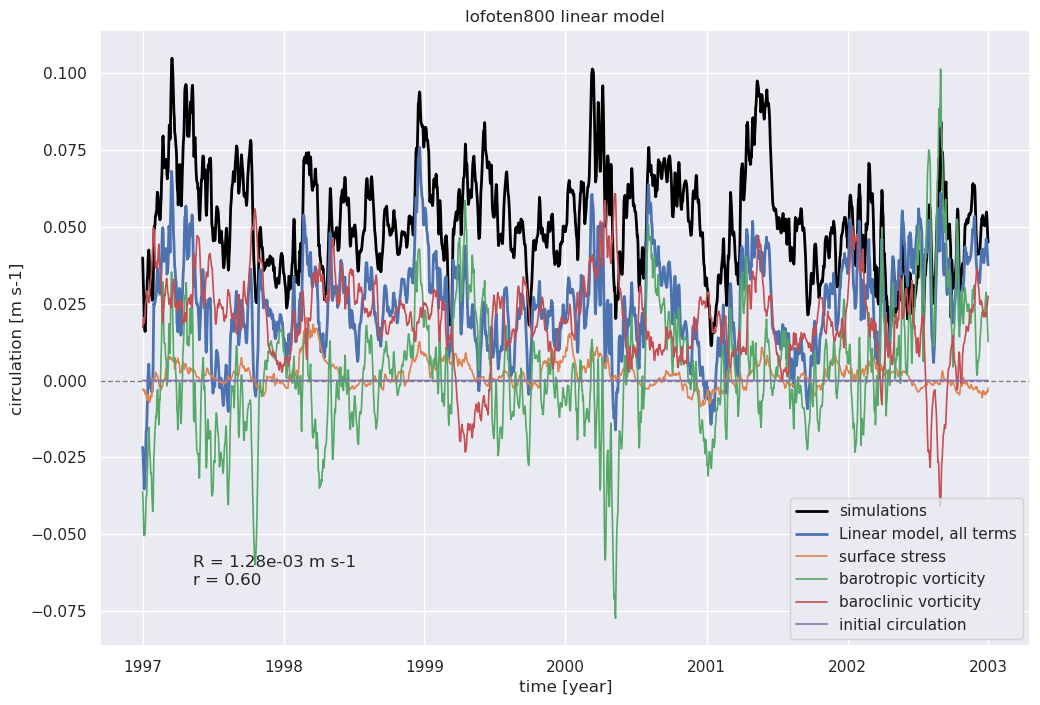

In [16]:
# Load the dataset
results = xr.open_dataset("data/lofoten800/lofoten800_estimates_lofoten_h_50km.nc")
#results = results.sel(ocean_time=slice("01.01.1997", None))


# Define terms for different components of circulation
# Note: there are two different posibilities for initial condition. Comment out the one not used
all_terms = [
    #'initial bottom circulation', 
    'surface stress', 
    #"planetary vorticity",
    'barotropic vorticity', 
    'baroclinic vorticity',
    'initial circulation', 
]
wind_terms = [
    'initial circulation', 
    #'initial bottom circulation', 
    'surface stress'
]
vorticity_terms = [
    #'initial bottom circulation', 
    #"planetary vorticity",
    'barotropic vorticity', 
    'baroclinic vorticity',
    'initial circulation', 
]

# Calculate sum of selected terms
results["all terms"] = results.Uestimates.sel(term=all_terms).sum("term")
results["wind-driven"] = results.Uestimates.sel(term=wind_terms).sum("term")
results["vorticity-driven"] = results.Uestimates.sel(term=vorticity_terms).sum("term")

# Choose x for correlation calculation
# Fill missing values with zeros for the correlation calculation
x = results.Ubar.fillna(0).values

# Calculate Pearson correlation coefficients for each R value
rs = []
for R in results.R:
    # chose y for correlation calculation. Could also be wind-driven or vorticity-driven components
    y = results.sel(R=R)["all terms"].fillna(0).values
    corr = sp.stats.pearsonr(x, y)
    r = corr.statistic
    p = corr.pvalue
    rs.append(r)

# Store correlation coefficients in the dataset
rs = np.array(rs)
results["r"] = ("R", rs)

# Find the R value with the maximum correlation coefficient. Can also set R manually
R = results.r.idxmax().values

# Select the dataset for the optimal R value
ds = results.sel(R=R)

r = ds.r.values
t = ds.ocean_time.values

# Plot each individual term over time
fig, ax = plt.subplots(figsize=figsize)

ax.axhline(0, lw=1,  ls="--", color="gray")
ax.plot(t,ds.Ubar, label="simulations", color="black", lw=2)
#ax.plot(t,ds.Ub, label="bottom", color="gray", lw=2)
ax.plot(t,ds["all terms"], label="Linear model, all terms", lw=2)

ax.text(0.1, 0.1, f"R = {R:.2e} m s-1\nr = {r:.2f}", transform=ax.transAxes)


ax.legend()
for term in all_terms:
    ax.plot(t,ds.sel(term=term).Uestimates, label=term, lw=1.2)
    
ax.legend()
ax.set_xlabel("time [year]")
ax.set_ylabel("circulation [m s-1]")

ax.set_title("lofoten800 linear model")